## <u>Implementing A Neural Network For CIFAR-10</u>

### Importing Libraries And Data

In [60]:
import os
import time
import random
import numpy as np
from matplotlib import pyplot as plt

## setting options for matplotlib prior
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## function to return relative error
def rel_error(x, y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))


### Activation Function

In [61]:
def relu(x):
    return np.maximum(0,x)

## TwoLayerNet Class

In [62]:
## ------------------------------------------- class begins ----------------------------------------------------------------
class TwoLayerNet(object):
    
    """
    A two-layer fully-connected neural network. The net has an input dimension of
    N, a hidden layer dimension of H, and performs classification over C classes.
    We train the network with a softmax loss function and L2 regularization on the
    weight matrices. The network uses a ReLU nonlinearity after the first fully
    connected layer.

    In other words, the network has the following architecture:

    input - fully connected layer - ReLU - fully connected layer - softmax

    The outputs of the second fully-connected layer are the scores for each class.
    """
    
    ## ---------------------------------------- init method ----------------------------------------------------------
    
    def __init__(self, input_size, hidden_size, output_size, std = 1e-4):
        
        """
        Initialize the model. Weights are initialized to small random values and
        biases are initialized to zero. Weights and biases are stored in the
        variable self.params, which is a dictionary with the following keys:

        W1: First layer weights; has shape (D, H)
        b1: First layer biases; has shape (H,)
        W2: Second layer weights; has shape (H, C)
        b2: Second layer biases; has shape (C,)

        Inputs:
        - input_size: The dimension D of the input data.
        - hidden_size: The number of neurons H in the hidden layer.
        - output_size: The number of classes C.
        """
        
        self.params = {}
        self.params['W1'] = std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
    
    ## --------------------------------------------------- loss function --------------------------------------------
    
    def loss(self, x, y = None, reg=0.0):
        
        """
        Compute the loss and gradients for a two layer fully connected neural
        network.

        Inputs:
        - X: Input data of shape (N, D). Each X[i] is a training sample.
        - y: Vector of training labels. y[i] is the label for X[i], and each y[i] is
          an integer in the range 0 <= y[i] < C. This parameter is optional; if it
          is not passed then we only return scores, and if it is passed then we
          instead return the loss and gradients.
        - reg: Regularization strength.

        Returns:
        If y is None, return a matrix scores of shape (N, C) where scores[i, c] is
        the score for class c on input X[i].

        If y is not None, instead return a tuple of:
        - loss: Loss (data loss and regularization loss) for this batch of training
          samples.
        - grads: Dictionary mapping parameter names to gradients of those parameters
          with respect to the loss function; has the same keys as self.params.
        """
        
        ## unpacking variables from the params dictionary
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        
        ## ---------------------------------------------forward pass----------------------------------------------
        
        ## x is  (N, D) and W1 is (D, hidden) and hence, Z1 is (N, hidden)
        z1 = np.dot(x, W1) + b1
        ## applying activation function
        a1 = relu(z1)
        ## Z1 is (N, hidden) and W2 is (hidden, C) and hence Z2 be should (N, C)
        scores = np.dot(a1, W2) +  b2 
        
        
        ## if targets are not given, jump out,
        ## we can't figure out loss and grads without targets
        if y is None:
            return scores
        
        ## ----------------------- computing softmax loss ----------------------------------------
        loss = None
        num_train = x.shape[0]
        
        ## shifting scores, because of overflow reasons
        scores -= scores.max()
        ## dimensions of scores is (N, C)
        scores = np.exp(scores)
        ## dimensions of scores_sums is (N, )
        scores_sums = np.sum(scores, axis = 1)
        
        ## correct exponents
        cors = scores[range(num_train), y]
        
        ## loss
        loss = cors/scores_sums
        
        ## final loss
        loss = (-np.sum( np.log(loss) / num_train )) + reg * ( np.sum(W1*W1) + np.sum(W2*W2) )
        
        ## ------------------------------------------- backward pass -----------------------------------------------
        
        grads = {}
        
        '''
        preparing a softmax_matrix for calculating grads, if you are not able to understand
        this implementation, go to https://dianant.github.io/softmax_image/index.html and 
        understand both naive and vectorized implementations of lossAndGrads and you should be
        able to figure it out. Below is the full computation graph for this neural network. Now we 
        will backpropagate from the end one by one.
        
        Computation Graph
        -----------------
        '''
        
        # W1
        # ----+                      W2         b2
        # dW2  \                     ----+      ----+
        #      (*)----+              dW2  \     db2  \
        # X    /       \                   \          \  
        # ----+         \               a1   \          \   scores           softmaxes
        #               (+)------(ReLU)-----(*)--------(+)--------(softmax)----------
        # b1            /  drelu        da1      dscores    dscores 
        # -------------+
        # db1

        
        
        '''
        dscores = (d(softmax(scores)))*(d(softmaxes)/d(softmaxes))
        dscores = d(softmax(scores)) * 1
        '''
        
        ## for all the classes
        dscores = np.divide(scores, scores_sums.reshape(num_train, 1))
        ## for the correct classes
        dscores[ range(num_train), y] = - (scores_sums - cors) / scores_sums
        ## averaging gradients for all the training examples
        dscores = dscores / num_train ## dscores is (N, C)
        
        ## db2 should be equal to dscores but
        ## db2 should have a shape of (C, )
        db2 = np.sum(dscores, axis = 0)
        ## ---------------------------------------------------------------------
        ## calculating grads for W2
        ## a1 is (N, hidden) and dscores is (N, C) but, dW2 should be (hidden, C)
        dW2 = np.dot(a1.transpose(), dscores)
        
        ## ---------------------------------------------------------------------
        
        ##  da1 = W2 * dscores || (hidden, C) * (N, C) || da1 should be (N, hidden)
        da1 = np.dot(dscores, W2.transpose())
        ## ---------------------------------------------------------------------
        
        ## relu derivative
        drelu = (z1 > 0)*(da1)
        ## ---------------------------------------------------------------------
        
        ## db1 would be equal to drelu but shapes need to be adjusted
        ## drelu has a shape of (N, hidden) and db1 should be (hidden, )
        db1 = np.sum(drelu, axis = 0)
        ## ----------------------------------------------------------------------
        
        ## dW1 should be like (x * drelu)
        ## dW1 should be (D, hidden) || X is (N,D) and drelu is (N, hidden)
        dW1 = np.dot(x.transpose(), drelu)
        
        ## -------------------------------------- updating gradients of weights and biases -----------------------
        grads['W2'] = dW2 + 2 * reg * W2
        grads['b2'] = db2
        grads['W1'] = dW1 + 2 * reg * W1
        grads['b1'] = db1
        
        return loss, grads
    
    ## ---------------------------------------------- train (SGD) function ---------------------------------------
    
    def train(self, x, y, x_val, y_val, learning_rate = 1e-3, learning_rate_decay = 0.95,
              reg = 5e-6, num_iters = 100, batch_size = 200, verbose = False):
        
        """
        Train this neural network using stochastic gradient descent.
        Inputs:
        - X: A numpy array of shape (N, D) giving training data.
        - y: A numpy array f shape (N,) giving training labels; y[i] = c means that
          X[i] has label c, where 0 <= c < C.
        - X_val: A numpy array of shape (N_val, D) giving validation data.
        - y_val: A numpy array of shape (N_val,) giving validation labels.
        - learning_rate: Scalar giving learning rate for optimization.
        - learning_rate_decay: Scalar giving factor used to decay the learning rate
        after each epoch.
        - reg: Scalar giving regularization strength.
        - num_iters: Number of steps to take when optimizing.
        - batch_size: Number of training examples to use per step.
        - verbose: boolean; if true print progress during optimization.
        """
        
        num_train = x.shape[0]
        iterations_per_epoch = max(num_train/batch_size, 1)
        
        ## use SGD to optimize the parameters
        loss_history = []
        train_accuracy_history = []
        val_accuracy_history = []
        
        
        for it in range(num_iters):
            
            ## creating a mini batch of random indices
            batch_ind = np.random.choice(num_train, batch_size)
            x_batch = x[batch_ind]
            y_batch = y[batch_ind]
            
            ## computing loss and grads using the current minibatch
            loss, grads = self.loss(x_batch, y = y_batch, reg = reg)
            loss_history.append(loss)
            
            ## using calculated grads to change the values of the parameters
            self.params['W1'] = self.params['W1'] - learning_rate * grads['W1']
            self.params['b1'] = self.params['b1'] - learning_rate * grads['b1']
            self.params['W2'] = self.params['W2'] - learning_rate * grads['W2']
            self.params['b2'] = self.params['b2'] - learning_rate * grads['b2']
            
            
            ## displaying the progress
            if verbose == True and it % 100 == 0:
                print('Iteration {} / {}: loss {}'.format(it, num_iters, loss))
            
            ## for every epoch, check train, val accuracy and decay learning_rate
            if it % iterations_per_epoch == 0:
                ## check accuracy
                train_acc = (self.predict(x_batch) == y_batch).mean()
                val_acc = (self.predict(x_val) == y_val).mean()
                train_accuracy_history.append(train_acc)
                val_accuracy_history.append(val_acc)
                
                ## decay learning rate
                learning_rate = learning_rate * learning_rate_decay
                
        
        return {
            'loss_history': loss_history,
            'train_accuracy_history': train_accuracy_history,
            'val_accuracy_history': val_accuracy_history
        }
    
    ## ------------------------------------------ predict function ----------------------------------------------
    
    def predict(self, x):
        
        ## we will now pass examples to be predicted (forward pass) through the network with trained weights.
        ## and then we'll use np.argmax() to extract labels from one hot array
        
        ## x is (N,D) and W1 is (D, hidden)
        h1 = np.dot(x, self.params['W1']) + self.params['b1']  ## h1 is (N, hidden)
        ## applying ReLu activation function to h1
        h1 = np.maximum(0, h1)
        
        ## h1 is (N, hidden) and W2 is (hidden, C)
        h2 = np.dot(h1, self.params['W2']) + self.params['b2']  ## h2 is (N, C)
        
        ## extracting labels from one hot array
        h2 = np.argmax(h2, axis = 1)
        
        return h2   
    
## ------------------------------------------ TwoLayerNet Class Ends ---------------------------------------------------------

### Toy Model
#### Creating A Toy Model To Check Our Implementations

In [63]:
## setting parameters
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std = 1e-1)
    
def init_toy_data():
    np.random.seed(1)
    x = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return x, y

net = init_toy_model()
x, y = init_toy_data()

### Forward Pass : Compute Scores

In [64]:
scores = net.loss(x)
print(' Your Scores: ')
print(scores)

## correct scores are given and now we'll try to find the difference between correct and these calulated scores

print('\n\nCorrect Scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores,"\n\n")

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

 Your Scores: 
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]


Correct Scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]] 


Difference between your scores and correct scores:
3.6802720745909845e-08


### Forward Pass: Computing Loss

In [65]:
loss, _ = net.loss(x, y, reg = 0.05)
correct_loss = 1.303787

## difference between calculated and correct loss should be very small
print(' Difference between correct and calculated loss : ',end=" ")
print(np.sum(np.abs(loss - correct_loss)))

 Difference between correct and calculated loss :  8.913298203960807e-07


### Gradient Checking

In [66]:
def eval_numerical_gradient(f, x, verbose = False, h = 0.00001):
    
    ## returns the numerical gradient of funtion f at point x
    
    fx = f(x)
    grad = np.zeros_like(x)
    
    ## iterate over all indexes in x
    it = np.nditer(x, flags = ['multi_index'], op_flags = ['readwrite'])
    
    while not it.finished:
        
        ## evaluate function at (x + h)
        ix = it.multi_index
        oldval = x[ix]
        ## increment by h
        x[ix] = oldval + h
        fxph = f(x)
        ## decrement by h
        x[ix] = oldval - h
        fxmh = f(x)
        ## restoring the previous value
        x[ix] = oldval
        
        ## computing partial derivatives with centered formulae
        
        grad[ix] = (fxph - fxmh) / (2 * h) ## the slope
        
        if verbose:
            print(ix, grad[ix])
        ## step to next dimension
        it.iternext()
    
    return grad

 
### Backward Pass <br>

In [67]:
## using gadient cheking to calculate the difference between analytic and numerical gradients.
## if analytic gradients are correct than, difference between them should be very less.

loss, grads = net.loss(x, y, reg = 0.05)

## all the differences should be very less, say less than 1e-8
for param_name in grads:
    
    f = lambda W: net.loss(x, y, reg = 0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose = False)
    print('{} Max Relative Error: {}'.format(param_name, rel_error(param_grad_num, grads[param_name])))
    

W2 Max Relative Error: 3.440707836450643e-09
b2 Max Relative Error: 3.8650699394205354e-11
W1 Max Relative Error: 3.5613181785044393e-09
b1 Max Relative Error: 2.7384209701975995e-09


## Training The Network 
 We are going to use Stochastic Gradient Descent to  optimize the parameters just as we did in the softmax and the SVM Classifiers

Final training loss:  0.017149607938732065


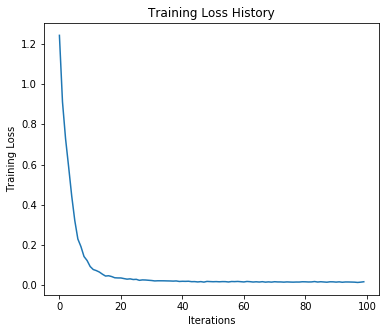

In [68]:
net = init_toy_model()
stats = net.train(x, y, x, y, learning_rate = 1e-1, reg = 5e-6, num_iters = 100, verbose = False)

## printing the loss from the final iteration
print('Final training loss: ', stats['loss_history'][-1])

## plotting the loss history
plt.figure(figsize = (6,5))
plt.plot(stats['loss_history'])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')
plt.title('Training Loss History')
plt.show()

### Loading The CIFAR-10 Data
Now we have seen that our neural network works correctly on the toy data so it's time to implement it on the CIFAR10 Dataset

In [69]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training = 49000, num_validation = 1000, num_test = 1000):
    
    ## loading data and dividing sets and perform preprocessing
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    x_train, y_train, x_test, y_test = load_CIFAR10(cifar10_dir)
    
    ## subsample the data 
    ## making validation set
    mask = list(range(num_training, num_training + num_validation))
    x_val = x_train[mask]
    y_val = y_train[mask]
    
    ## making training set
    mask = list(range(num_training))
    x_train = x_train[mask]
    y_train = y_train[mask]
    
    ## making test set
    mask = list(range(num_test))
    x_test = x_test[mask]
    y_test = y_test[mask]
    
    ## Normalizing the data, i.e. subtracting mean image from each data example
    mean_image = np.mean(x_train, axis = 0)
    x_train = x_train - mean_image
    x_val = x_val - mean_image
    x_test = x_test - mean_image
    
    ## reshape data into rows
    x_train = x_train.reshape(num_training, -1)
    x_val = x_val.reshape(num_validation, -1)
    x_test = x_test.reshape(num_test, -1)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

## Invokeing the above function for getting the data
x_train, y_train, x_val, y_val, x_test, y_test = get_CIFAR10_data()
## printing the shape for all the data numpy arrays
print('Train Data Shape: ', x_train.shape)
print('Train Labels Shape: ', y_train.shape)
print('Validation Data Shape: ', x_val.shape)
print('Validation Labels Shape: ', y_val.shape)
print('Test Data Shape: ', x_test.shape)
print('Test Labels Shape: ', y_test.shape)

Train Data Shape:  (49000, 3072)
Train Labels Shape:  (49000,)
Validation Data Shape:  (1000, 3072)
Validation Labels Shape:  (1000,)
Test Data Shape:  (1000, 3072)
Test Labels Shape:  (1000,)


### Training The Network

In [70]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

## training the network
stats = net.train(x_train, y_train, x_val, y_val, num_iters = 1000,
                  batch_size = 200, learning_rate = 1e-4, learning_rate_decay = 0.95,
                 reg = 0.25, verbose = True)

## predicting on the validation set
val_acc = np.mean( net.predict(x_val) == y_val)
print('\nValidation Accuracy: ', val_acc)

Iteration 0 / 1000: loss 2.3029542563326193
Iteration 100 / 1000: loss 2.302550284476177
Iteration 200 / 1000: loss 2.2976481282838637
Iteration 300 / 1000: loss 2.2596024838673645
Iteration 400 / 1000: loss 2.2041699420263394
Iteration 500 / 1000: loss 2.11856468202782
Iteration 600 / 1000: loss 2.0515351076500963
Iteration 700 / 1000: loss 1.9884657713627063
Iteration 800 / 1000: loss 2.006590833171524
Iteration 900 / 1000: loss 1.9514727453386582

Validation Accuracy:  0.287


### Debugging The Training

With the parameters we used above we got an accuracy of about 0.29 on the validation set. This isn't very good. One thing we can do to debug our networks is to plot the loss and the accuracies of the training and the validation sets during optimization. <br><br>
Another strategy is to visualize the weights that were learnt in the first layer of the network.

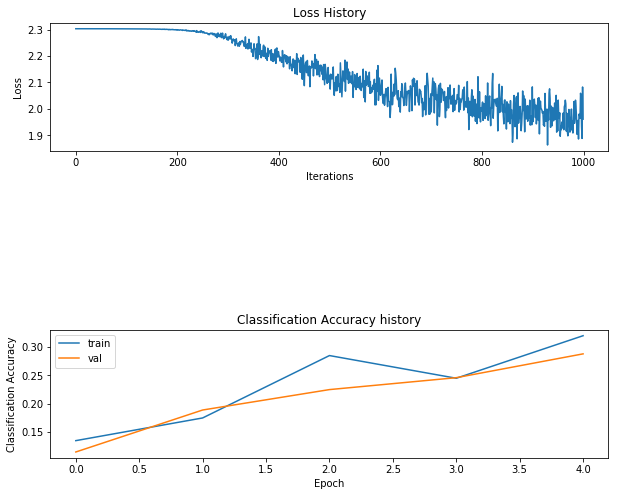

In [71]:
## plotting the loss functions and the training and validation accuracies

plt.subplot(3, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss History')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.subplot(3, 1, 3)
plt.plot(stats['train_accuracy_history'], label = 'train')
plt.plot(stats['val_accuracy_history'], label = 'val')
plt.legend()
plt.title('Classification Accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification Accuracy')
plt.show()

### Visualizing The Weights of The Network

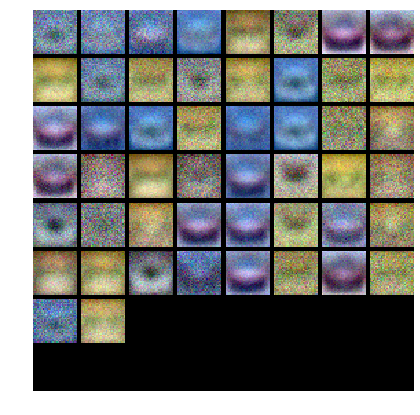

In [72]:
from cs231n.vis_utils import visualize_grid

def show_net_weights(net):
    W1 = net.params['W1']
    plt.figure(figsize= (7,7))
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2) ## shape after transpose (-1, 32, 32, 3)
    plt.imshow(visualize_grid(W1, padding = 3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()
    
show_net_weights(net)

## Tune your hyperparameters <br>
<b>What's wrong?.</b> Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy. <br>

<b>Tuning.</b> Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks. Below, you can experiment with different values of the various hyperparameters, including hidden layer size, learning rate, numer of training epochs, and regularization strength. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.<br>

<b>Approximate results.</b> We should aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.<br>

<b>Experiment:</b> Our goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network..<br>

In [73]:
## we'll store the best net into this variable
best_net = None

## defining parameters to sweep through
hidden_size = [40, 60, 80, 100, 120]
learning_rate = [1e-4, 5e-4, 1e-3, 5e-3]
reg = [0.2, 0.4, 0.6]
best_acc = -1

log = {}

for hs in hidden_size:
    for lr in learning_rate:
        for r in reg:
            
            ## setting up the network
            net = TwoLayerNet(input_size, hs, num_classes)
            
            ## training the network
            stats = net.train(x_train, y_train, x_val, y_val, num_iters = 1000,
                             batch_size = 200, learning_rate = lr,
                             learning_rate_decay = 0.95, reg = r, verbose = False)
            
            acc = stats['val_accuracy_history'][-1]
            log[(hs, lr, r)] = acc
            
            ## print log
            print('For hidden_size: {}, lr: {} and reg: {} || val_accuracy: {}'.format(hs,lr,r,acc))
            
            if acc > best_acc:
                best_acc = acc
                best_net = net
                
print('Best Network Has The Validation Accuracy: ', best_acc)


For hidden_size: 40, lr: 0.0001 and reg: 0.2 || val_accuracy: 0.281
For hidden_size: 40, lr: 0.0001 and reg: 0.4 || val_accuracy: 0.282
For hidden_size: 40, lr: 0.0001 and reg: 0.6 || val_accuracy: 0.287
For hidden_size: 40, lr: 0.0005 and reg: 0.2 || val_accuracy: 0.437
For hidden_size: 40, lr: 0.0005 and reg: 0.4 || val_accuracy: 0.444
For hidden_size: 40, lr: 0.0005 and reg: 0.6 || val_accuracy: 0.448
For hidden_size: 40, lr: 0.001 and reg: 0.2 || val_accuracy: 0.468
For hidden_size: 40, lr: 0.001 and reg: 0.4 || val_accuracy: 0.447
For hidden_size: 40, lr: 0.001 and reg: 0.6 || val_accuracy: 0.483


c:\users\anant agarwal\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:341: RuntimeWarning: invalid value encountered in true_divide
c:\users\anant agarwal\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:344: RuntimeWarning: divide by zero encountered in log
c:\users\anant agarwal\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:380: RuntimeWarning: invalid value encountered in true_divide
c:\users\anant agarwal\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:382: RuntimeWarning: invalid value encountered in true_divide
c:\users\anant agarwal\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:401: RuntimeWarning: invalid value encountered in greater


For hidden_size: 40, lr: 0.005 and reg: 0.2 || val_accuracy: 0.087
For hidden_size: 40, lr: 0.005 and reg: 0.4 || val_accuracy: 0.087
For hidden_size: 40, lr: 0.005 and reg: 0.6 || val_accuracy: 0.087
For hidden_size: 60, lr: 0.0001 and reg: 0.2 || val_accuracy: 0.291
For hidden_size: 60, lr: 0.0001 and reg: 0.4 || val_accuracy: 0.276
For hidden_size: 60, lr: 0.0001 and reg: 0.6 || val_accuracy: 0.278
For hidden_size: 60, lr: 0.0005 and reg: 0.2 || val_accuracy: 0.456
For hidden_size: 60, lr: 0.0005 and reg: 0.4 || val_accuracy: 0.446
For hidden_size: 60, lr: 0.0005 and reg: 0.6 || val_accuracy: 0.45
For hidden_size: 60, lr: 0.001 and reg: 0.2 || val_accuracy: 0.449
For hidden_size: 60, lr: 0.001 and reg: 0.4 || val_accuracy: 0.474
For hidden_size: 60, lr: 0.001 and reg: 0.6 || val_accuracy: 0.449
For hidden_size: 60, lr: 0.005 and reg: 0.2 || val_accuracy: 0.087
For hidden_size: 60, lr: 0.005 and reg: 0.4 || val_accuracy: 0.087
For hidden_size: 60, lr: 0.005 and reg: 0.6 || val_accura

### Visualzing The Weights of The Best Network

It can be clearly observed that the weights template generated now when val_accuracy is 0.49 are so much more feature rich as compared to the above weight templates when val_accuracy was about 0.29

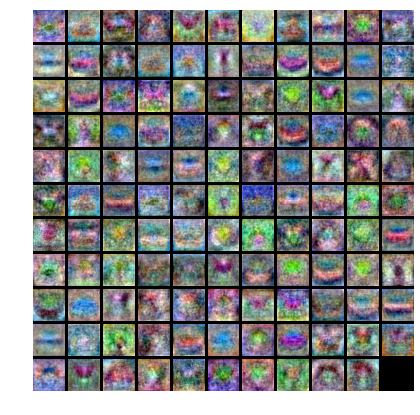

In [74]:
## using the above created show_net_weights() function
show_net_weights(best_net)

### Accuracy On The Test Set

In [75]:
test_acc = (best_net.predict(x_test) == y_test).mean()
print('Test Accuracy: ', test_acc)

Test Accuracy:  0.489
